In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from os.path import join

from models.base_line import BasicModel
from training.trainer_base import Trainer
from data.transforms import ResizeTransform
from modules.cross_validation import MyKFoldCV
from modules.dataset_handling import DatasetHandler
from modules.logging import MyLogger
from utils.metrics import compute_confusion_matrices, compute_accuracy, compute_f1score
from utils.visulisation import visualize_confusion_matrices


torch.manual_seed(42)


in_size = 128
out_size = 2

project_path = "/home/gatemrou/uds/Eye_Tracking/"
assert(os.path.exists(project_path))

In [2]:
data_type = 'heatmap'       # scanpath or heatmap
scanpath_type = None        # a, b or c
model_type = 'base'      # def_cnn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if model_type == 'base':
    model = BasicModel(in_size, out_size)
print('using device: ' + device.__str__())
# Create a dataset from image folder
root = join(project_path, 'data/datasets/{}s/'.format(data_type))
if data_type == 'scanpath':
    root = join(root, '{}/'.format(scanpath_type))

transform = ResizeTransform(in_size, in_size)

dataset = DatasetHandler(root, transform)

outer_kfolds = 8
inner_kfolds = 7
batch_size = 32

outer_cv = MyKFoldCV(dataset, outer_kfolds, create_train_loaders=False, batch_size=batch_size)

learning_rate = 0.02

# Define the loss function
loss = nn.CrossEntropyLoss()

logger = MyLogger(join(project_path, 'experiments/{}s_{}_{}'.format(data_type, model_type, in_size)))

# Define trainer 
save_path = join(project_path, 'saved_models/{}s_{}'.format(data_type, model_type))

trainer = Trainer(model, save_path, loss, logger=logger)

using device: cuda


In [3]:
num_epochs = 5

for i in range(outer_cv.k):
    print(f'outer fold: {i+1}')
    logger.log_new_fold(i, outer_cv.get_test_participants())
    if model_type == 'base':
        model = BasicModel(in_size, out_size)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    trainer.set_optimizer(optimizer)
    trainer.set_model(model)
    inner_cv = MyKFoldCV(dataset, inner_kfolds, ignore=outer_cv.get_test_participants(), batch_size=batch_size)
    print('testing on: ', outer_cv.get_test_participants())
    print('training on: ', inner_cv.get_participants())
    # training
    for j in range(inner_cv.k):
        print(f'inner fold: {j+1}')
        train_loader = inner_cv.get_train_loader()
        test_loader = inner_cv.get_test_loader()
        print('validating on: ', inner_cv.get_test_participants())
        trainer.set_train_loader(train_loader)
        trainer.set_val_loader(test_loader)
        for _ in range(num_epochs):
            trainer.run_epoch()
        inner_cv.next_split()
    trainer.load_best_model()
    # testing
    test_loader = outer_cv.get_test_loader()
    test_model = trainer.model
    test_model.eval()
    for p in outer_cv.get_test_participants():
        assert(p not in inner_cv.get_participants())
    acc = compute_accuracy(test_model, test_loader)
    f1 = compute_f1score(test_model, test_loader)
    cfs = compute_confusion_matrices(test_model, dataset, outer_cv.get_test_participants())
    trainer.reset()
    logger.log_test_metrics(acc, f1, cfs)
    outer_cv.next_split()
logger.log_f1_history()



outer fold: 1
testing on:  ['10', '11', '13', '14']
training on:  ['15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '28', '29', '3', '30', '31', '32', '33', '34', '35', '4', '5', '6', '7', '8', '9']
inner fold: 1
validating on:  ['15', '16', '17', '18']
20.03 23:36:44 --- Epoch [1], Loss: 0.8528, Val acc: 77.27
20.03 23:36:45 --- Epoch [2], Loss: 0.3065, Val acc: 90.91
20.03 23:36:46 --- Epoch [3], Loss: 0.2567, Val acc: 93.18
20.03 23:36:47 --- Epoch [4], Loss: 0.2365, Val acc: 90.91
20.03 23:36:48 --- Epoch [5], Loss: 0.2153, Val acc: 90.91
inner fold: 2
validating on:  ['19', '2', '20', '21']
20.03 23:36:49 --- Epoch [6], Loss: 0.2507, Val acc: 92.50
20.03 23:36:50 --- Epoch [7], Loss: 0.2036, Val acc: 92.50
20.03 23:36:51 --- Epoch [8], Loss: 0.1952, Val acc: 92.50
20.03 23:36:52 --- Epoch [9], Loss: 0.1666, Val acc: 92.50
20.03 23:36:53 --- Epoch [10], Loss: 0.1561, Val acc: 90.00
inner fold: 3
validating on:  ['22', '23', '24', '25']
20.03 23:36:54 ---

In [4]:
trainer.save_best_model()
print('testing on: ', outer_cv.get_test_participants())
trainer.test(outer_cv.get_test_loader())

Saving best model to   C:/Users/Admin/projects/Eye_Tracking/saved_models/heatmaps_def_cnn\best_model.pkl
testing on:  ['17', '18', '8', '2']


0.9545454545454546

In [13]:
test_model = BasicModel(in_size, out_size)
test_model.load_state_dict(torch.load(join(project_path, 'saved_models/heatmaps_def_cnn/best_model.pkl')))
test_pp = ['17', '18', '8', '2']

In [6]:
test_trainer = Trainer(test_model, save_path, loss, optimizer=optimizer)


In [11]:
print(compute_accuracy(test_model, dataset, test_pp))
print(compute_f1score(test_model, dataset, test_pp))

0.9545454545454546
0.953168044077135


In [11]:
outer_cv.get_test_participants()

['17', '18', '8', '2']

In [14]:
cfs = compute_confusion_matrices(test_model, dataset, test_pp)

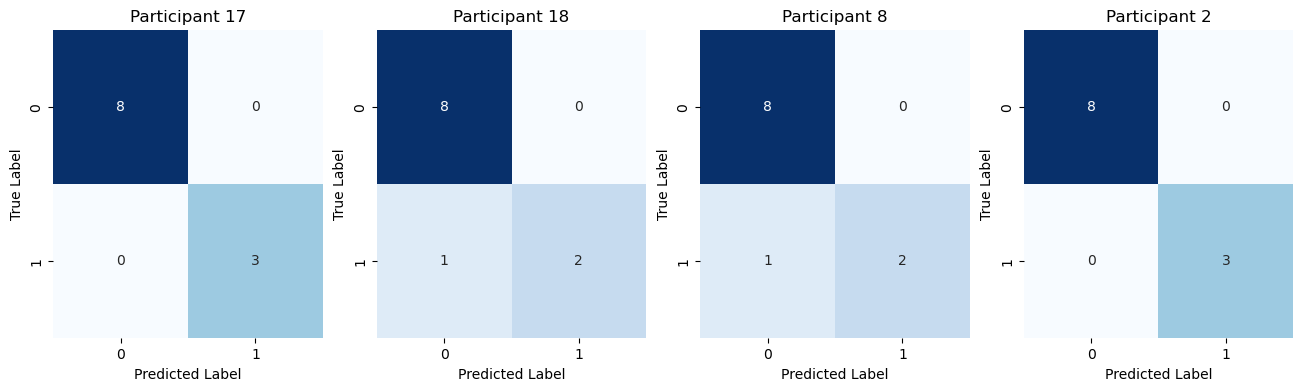

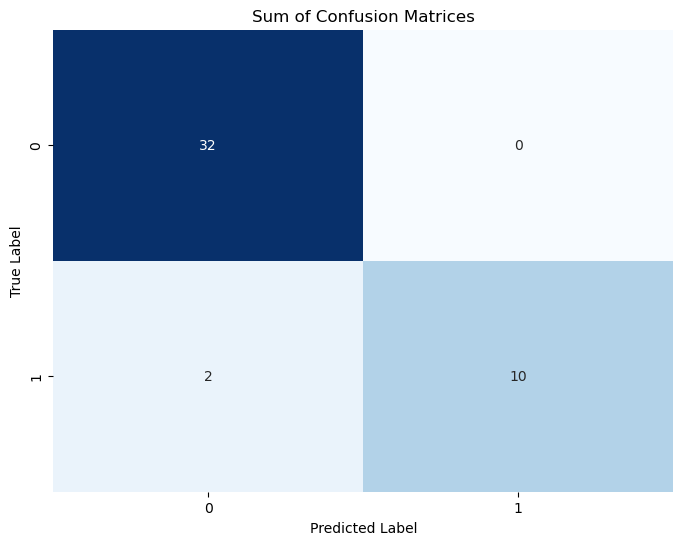

In [15]:
visualize_confusion_matrices(cfs)